# Loading Libraries

In [1]:
# Pandas, Numpy
import pandas as pd
import numpy as np 

# Tensorflow
import tensorflow as tf 

# RBM from Recommenders
from recommenders.models.rbm.rbm import RBM 
from recommenders.utils.timer import Timer 
from recommenders.utils.plot import line_graph 

# Affinity Matrix 
from recommenders.datasets.sparse import AffinityMatrix

# Evaluation 
from recommenders.evaluation.python_evaluation import (
    precision_at_k,
    recall_at_k
)
from sklearn.metrics import accuracy_score 

# Visualization
from matplotlib import pyplot as plt 

# Import & Read Dataset

In [2]:
# Read Train & Test Data
train = pd.read_csv("../../00_Data/rec_sys_binary_train.csv", index_col=0)
test = pd.read_csv("../../00_Data/rec_sys_binary_test.csv", index_col=0)

In [3]:
# Check Shapes
print("Shape of Train:", train.shape)
print("Shape of Test: \t", test.shape)

Shape of Train: (137627, 3)
Shape of Test: 	 (34505, 3)


In [4]:
# Check Number of Unique Items and User in Train & Test 
print("Unique Users in Train:", train.CustomerID.nunique())
print("Unique Users in Test:", test.CustomerID.nunique())
print("Unique Items in Train:", train.StockCode.nunique())
print("Unique Items in Test:", test.StockCode.nunique())

Unique Users in Train: 3011
Unique Users in Test: 3011
Unique Items in Train: 2307
Unique Items in Test: 2307


# Preparation of Datasets for Modeling 

In [5]:
# Set standard names for the analysis 
header = {
        "col_user": "CustomerID",
        "col_item": "StockCode",
        "col_rating": "purchased",
    }

# Instantiate the sparse matrix generation  
am_train = AffinityMatrix(df = train, col_user='CustomerID', col_item='StockCode', col_rating='purchased')
am_test = AffinityMatrix(df = test, col_user='CustomerID', col_item='StockCode', col_rating='purchased')

# Obtain the sparse matrix 
Xtr, _, _ = am_train.gen_affinity_matrix()
Xtst, _, _ = am_test.gen_affinity_matrix()

In [6]:
# Sanity Check: Print Shape of Train & Test Matrix - Do numbers match nr of unique users and items from above 
print(Xtr.shape)
print(Xtst.shape) 

(3011, 2307)
(3011, 2307)


In [7]:
# Sanity Check 2: Do the sum of values match number of instances in train and test set?
print(np.sum(Xtr))
print(np.sum(Xtst))

137627
34505


In [8]:
# Change Values above 0 to 5 for Top N training
Xtst = np.where(Xtst > 0, 5, Xtst)
Xtr = np.where(Xtr > 0, 5, Xtr)

In [9]:
# Sanity check: Xtr & Xtst After reloading & Transformation
print(np.unique(Xtr))
print(np.unique(Xtst))

[0 5]
[0 5]


# Modeling

## Hyperparameter Tuning 1 

In [10]:
# Set up Parameters 
hidden_neurons = [500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500]
batch = [100, 200, 300]
lrate = [0.001, 0.002, 0.003, 0.004]

# Initiate Lists for Assessment
recall_10 = []
recall_20 = []
precision_10 = []
precision_20 = []
neurons = []
batches = []
learning_rates = []

# Loop through lists of parameters 

for n in hidden_neurons:
    for b in batch:
        for l in lrate:
            # Delete Model First
            try:
                del(model)
            except:
                pass
            
            # Define Model with Parameters
            model = RBM(
                possible_ratings=[1., 5.], # Always provide this range - way better results! 
                visible_units=Xtr.shape[1],
                hidden_units=n,
                training_epoch=30,
                minibatch_size=b,
                keep_prob=0.7,
                with_metrics=True,
                learning_rate=l,
                seed=42
            )
            
            # Fit Model 
            model.fit(Xtr)
            
            # Recommend top k
            top_k = model.recommend_k_items(Xtst, top_k=20, remove_seen=True)
            
            # Map Back Xtst & Top K
            top_k_df = am_test.map_back_sparse(top_k, kind = 'prediction')
            test_df  = am_test.map_back_sparse(Xtst, kind='ratings')
            
            # Evaluation 
            recall_at_ten  = recall_at_k(test_df, top_k_df, col_user="CustomerID", col_item="StockCode", 
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=10)
            recall_at_twenty = recall_at_k(test_df, top_k_df, col_user="CustomerID", col_item="StockCode", 
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=20)
            precision_at_ten = precision_at_k(test_df, top_k_df, col_user='CustomerID', col_item='StockCode',
                                            col_rating ='purchased', col_prediction="prediction",
                                            relevancy_method='top_k', k = 10)
            precision_at_twenty = precision_at_k(test_df, top_k_df, col_user='CustomerID', col_item='StockCode',
                                col_rating ='purchased', col_prediction="prediction",
                                relevancy_method='top_k', k = 20)
            
            # Append lists 
            recall_10.append(recall_at_ten)
            recall_20.append(recall_at_twenty)
            precision_10.append(precision_at_ten)
            precision_20.append(precision_at_twenty)
            neurons.append(n)
            batches.append(b)
            learning_rates.append(l)
            
            # Print Results 
            print("Recall at 10 for ", n, "neurons:", recall_at_ten)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


2023-05-23 18:40:43.696690: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 18:40:43.734182: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)


Recall at 10 for  500 neurons: 0.4262966566430661
Recall at 10 for  500 neurons: 0.46687167160525694
Recall at 10 for  500 neurons: 0.47823505215170786
Recall at 10 for  500 neurons: 0.46876441338670943
Recall at 10 for  500 neurons: 0.37595973665210464
Recall at 10 for  500 neurons: 0.40895977977959147
Recall at 10 for  500 neurons: 0.4204960380419597
Recall at 10 for  500 neurons: 0.4434263560154705
Recall at 10 for  500 neurons: 0.36305923079871344
Recall at 10 for  500 neurons: 0.3766824028404099
Recall at 10 for  500 neurons: 0.39326912269058095
Recall at 10 for  500 neurons: 0.40406603206922714
Recall at 10 for  600 neurons: 0.513793482028079
Recall at 10 for  600 neurons: 0.4865672305738774
Recall at 10 for  600 neurons: 0.4239528711960317
Recall at 10 for  600 neurons: 0.35588856157594745
Recall at 10 for  600 neurons: 0.47335081287925335
Recall at 10 for  600 neurons: 0.5009443162177365
Recall at 10 for  600 neurons: 0.5104477342954088
Recall at 10 for  600 neurons: 0.51450503

In [11]:
# Create Dataframe out of the Results of the Hyperparameter Tuning 
df_tuning_1 = pd.DataFrame({
    "hidden_neurons": neurons,
    "minibatches": batches,
    "learning_rates":learning_rates,
    "recall@10": recall_10,
    "recall@20": recall_20,
    "precision@10":precision_10,
    "precision@20":precision_20
})
# Sort Values by recall@10 
df_tuning_1.sort_values(by='recall@10', ascending=False)

,hidden_neurons,minibatches,learning_rates,recall@10,recall@20,precision@10,precision@20
19,600,200,0.004,0.514505,0.661422,0.369412,0.252408
12,600,100,0.001,0.513793,0.652823,0.364995,0.247260
18,600,200,0.003,0.510448,0.646845,0.364796,0.246031
17,600,200,0.002,0.500944,0.625626,0.356825,0.236284
23,600,300,0.004,0.496468,0.627783,0.354068,0.237629
...,...,...,...,...,...,...,...
75,1100,100,0.004,0.095103,0.172897,0.097874,0.089455
111,1400,100,0.004,0.094979,0.176319,0.101528,0.095666
98,1300,100,0.003,0.094121,0.164680,0.097376,0.087645
123,1500,100,0.004,0.086640,0.169832,0.095782,0.093922


## Hyperparameter Tuning 2

In [12]:
# Set up Parameters 
hidden_neurons = [550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650]
batch = [100, 200, 300]
lrate = [0.001, 0.002, 0.003, 0.004]

# Initiate Lists for Assessment
recall_10 = []
recall_20 = []
precision_10 = []
precision_20 = []
neurons = []
batches = []
learning_rates = []

# Loop through lists of parameters 

for n in hidden_neurons:
    for b in batch:
        for l in lrate:
            # Delete Model First
            try:
                del(model)
            except:
                pass
            
            # Define Model with Parameters
            model = RBM(
                possible_ratings=[1., 5.], # Always provide this range - way better results! 
                visible_units=Xtr.shape[1],
                hidden_units=n,
                training_epoch=30,
                minibatch_size=b,
                keep_prob=0.7,
                with_metrics=True,
                learning_rate=l,
                seed=42
            )
            
            # Fit Model 
            model.fit(Xtr)
            
            # Recommend top k
            top_k = model.recommend_k_items(Xtst, top_k=20, remove_seen=True)
            
            # Map Back Xtst & Top K
            top_k_df = am_test.map_back_sparse(top_k, kind = 'prediction')
            test_df  = am_test.map_back_sparse(Xtst, kind='ratings')
            
            # Evaluation 
            recall_at_ten  = recall_at_k(test_df, top_k_df, col_user="CustomerID", col_item="StockCode", 
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=10)
            recall_at_twenty = recall_at_k(test_df, top_k_df, col_user="CustomerID", col_item="StockCode", 
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=20)
            precision_at_ten = precision_at_k(test_df, top_k_df, col_user='CustomerID', col_item='StockCode',
                                            col_rating ='purchased', col_prediction="prediction",
                                            relevancy_method='top_k', k = 10)
            precision_at_twenty = precision_at_k(test_df, top_k_df, col_user='CustomerID', col_item='StockCode',
                                col_rating ='purchased', col_prediction="prediction",
                                relevancy_method='top_k', k = 20)
            
            # Append lists 
            recall_10.append(recall_at_ten)
            recall_20.append(recall_at_twenty)
            precision_10.append(precision_at_ten)
            precision_20.append(precision_at_twenty)
            neurons.append(n)
            batches.append(b)
            learning_rates.append(l)
            
            # Print Results 
            print("Recall at 10 for ", n, "neurons:", recall_at_ten)

Recall at 10 for  550 neurons: 0.46545894535851606
Recall at 10 for  550 neurons: 0.4899689197131144
Recall at 10 for  550 neurons: 0.4599159774416928
Recall at 10 for  550 neurons: 0.40218217006359186
Recall at 10 for  550 neurons: 0.41790923686134807
Recall at 10 for  550 neurons: 0.44181788160807955
Recall at 10 for  550 neurons: 0.4642023416362138
Recall at 10 for  550 neurons: 0.4778072649883429
Recall at 10 for  550 neurons: 0.4034359903727609
Recall at 10 for  550 neurons: 0.4129961498049898
Recall at 10 for  550 neurons: 0.43147793981985993
Recall at 10 for  550 neurons: 0.44627271629820336
Recall at 10 for  560 neurons: 0.4837748871000331
Recall at 10 for  560 neurons: 0.5133319450211827
Recall at 10 for  560 neurons: 0.5225565571461354
Recall at 10 for  560 neurons: 0.5168835047009119
Recall at 10 for  560 neurons: 0.4367656056022793
Recall at 10 for  560 neurons: 0.46288595928242665
Recall at 10 for  560 neurons: 0.483545830692309
Recall at 10 for  560 neurons: 0.50034761584

In [13]:
# Create Dataframe out of the Results of the Hyperparameter Tuning 
df_tuning_2 = pd.DataFrame({
    "hidden_neurons": neurons,
    "minibatches": batches,
    "learning_rates":learning_rates,
    "recall@10": recall_10,
    "recall@20": recall_20,
    "precision@10":precision_10,
    "precision@20":precision_20
})
# Sort Values by recall@10 
df_tuning_2.sort_values(by='recall@10', ascending=False)

,hidden_neurons,minibatches,learning_rates,recall@10,recall@20,precision@10,precision@20
14,560,100,0.003,0.522557,0.651226,0.368316,0.244753
54,590,200,0.003,0.517926,0.659311,0.368084,0.248157
66,600,200,0.003,0.517830,0.650312,0.367785,0.246596
91,620,200,0.004,0.517295,0.662159,0.374062,0.252657
60,600,100,0.001,0.516986,0.651178,0.367087,0.246878
...,...,...,...,...,...,...,...
74,610,100,0.003,0.247217,0.445539,0.208004,0.189090
110,640,100,0.003,0.226808,0.412411,0.193524,0.177084
123,650,100,0.004,0.213391,0.415448,0.185055,0.180389
75,610,100,0.004,0.188408,0.354766,0.161275,0.153454


# Final Tuning Round

In [19]:
# Set up Parameters 
hidden_neurons = [551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569]
batch = [100, 200]
lrate = [0.003, 0.004]

# Initiate Lists for Assessment
recall_10 = []
recall_20 = []
precision_10 = []
precision_20 = []
neurons = []
batches = []
learning_rates = []

# Loop through lists of parameters 

for n in hidden_neurons:
    for b in batch:
        for l in lrate:
            # Delete Model First
            try:
                del(model)
            except:
                pass
            
            # Define Model with Parameters
            model = RBM(
                possible_ratings=[1., 5.], # Always provide this range - way better results! 
                visible_units=Xtr.shape[1],
                hidden_units=n,
                training_epoch=30,
                minibatch_size=b,
                keep_prob=0.7,
                with_metrics=True,
                learning_rate=l,
                seed=42
            )
            
            # Fit Model 
            model.fit(Xtr)
            
            # Recommend top k
            top_k = model.recommend_k_items(Xtst, top_k=20, remove_seen=True)
            
            # Map Back Xtst & Top K
            top_k_df = am_test.map_back_sparse(top_k, kind = 'prediction')
            test_df  = am_test.map_back_sparse(Xtst, kind='ratings')
            
            # Evaluation 
            recall_at_ten  = recall_at_k(test_df, top_k_df, col_user="CustomerID", col_item="StockCode", 
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=10)
            recall_at_twenty = recall_at_k(test_df, top_k_df, col_user="CustomerID", col_item="StockCode", 
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=20)
            precision_at_ten = precision_at_k(test_df, top_k_df, col_user='CustomerID', col_item='StockCode',
                                            col_rating ='purchased', col_prediction="prediction",
                                            relevancy_method='top_k', k = 10)
            precision_at_twenty = precision_at_k(test_df, top_k_df, col_user='CustomerID', col_item='StockCode',
                                col_rating ='purchased', col_prediction="prediction",
                                relevancy_method='top_k', k = 20)
            
            # Append lists 
            recall_10.append(recall_at_ten)
            recall_20.append(recall_at_twenty)
            precision_10.append(precision_at_ten)
            precision_20.append(precision_at_twenty)
            neurons.append(n)
            batches.append(b)
            learning_rates.append(l)
            
            # Print Results 
            print("Recall at 10 for ", n, "neurons:", recall_at_ten)

Recall at 10 for  551 neurons: 0.49165539035082906
Recall at 10 for  551 neurons: 0.45799694825816656
Recall at 10 for  551 neurons: 0.467912555480259
Recall at 10 for  551 neurons: 0.48129810592933076
Recall at 10 for  552 neurons: 0.46826635370499825
Recall at 10 for  552 neurons: 0.4316303750781974
Recall at 10 for  552 neurons: 0.46142629314069095
Recall at 10 for  552 neurons: 0.4740044339775458
Recall at 10 for  553 neurons: 0.47136187530642853
Recall at 10 for  553 neurons: 0.4146719452863199
Recall at 10 for  553 neurons: 0.48610187852385045
Recall at 10 for  553 neurons: 0.49155114922107757
Recall at 10 for  554 neurons: 0.5016728172357412
Recall at 10 for  554 neurons: 0.4888287664935888
Recall at 10 for  554 neurons: 0.46285259400310025
Recall at 10 for  554 neurons: 0.47595308720563123
Recall at 10 for  555 neurons: 0.4926708266743233
Recall at 10 for  555 neurons: 0.4815308760961171
Recall at 10 for  555 neurons: 0.445722460445454
Recall at 10 for  555 neurons: 0.459226532

In [20]:
# Create Dataframe out of the Results of the Hyperparameter Tuning 
df_tuning_3 = pd.DataFrame({
    "hidden_neurons": neurons,
    "minibatches": batches,
    "learning_rates":learning_rates,
    "recall@10": recall_10,
    "recall@20": recall_20,
    "precision@10":precision_10,
    "precision@20":precision_20
})
# Sort Values by recall@10 
df_tuning_3.sort_values(by='recall@10', ascending=False)

,hidden_neurons,minibatches,learning_rates,recall@10,recall@20,precision@10,precision@20
45,562,100,0.004,0.539653,0.651604,0.377449,0.245367
44,562,100,0.003,0.537268,0.641736,0.374826,0.241348
36,560,100,0.003,0.522622,0.651000,0.367187,0.244802
21,556,100,0.004,0.518349,0.645681,0.364962,0.244271
37,560,100,0.004,0.516956,0.663727,0.368283,0.250482
...,...,...,...,...,...,...,...
65,567,100,0.004,0.352595,0.606645,0.276353,0.234789
24,557,100,0.003,0.261494,0.464619,0.211093,0.187529
48,563,100,0.003,0.255876,0.469890,0.210628,0.191581
25,557,100,0.004,0.197685,0.357472,0.164763,0.151212


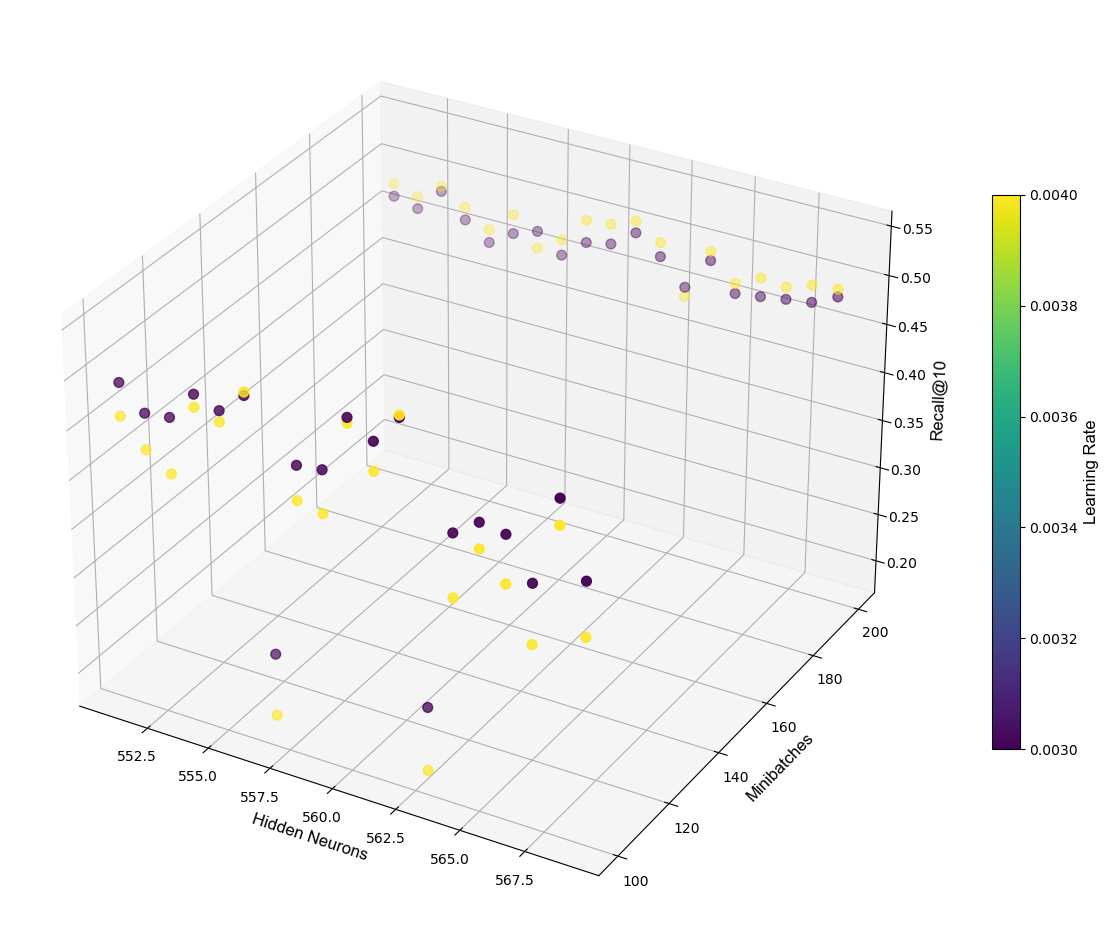

In [21]:
fig = plt.figure(figsize=(15,12))
plt.rcParams.update({'font.size': 10})
ax = fig.add_subplot(projection='3d')

x, y, z = df_tuning_3.hidden_neurons, df_tuning_3['minibatches'], df_tuning_3['recall@10']
ax.set_xlabel('Hidden Neurons', fontname='Arial', fontsize=12)
ax.set_ylabel('Minibatches',fontname='Arial', fontsize=12)
ax.set_zlabel('Recall@10',fontname='Arial', fontsize=12)
scatter = ax.scatter(x,y,z, cmap='viridis', marker='o', s=50, c=df_tuning_3['learning_rates'])

# Colorbar
cbar = plt.colorbar(scatter, shrink=0.6)
cbar.set_label('Learning Rate', fontname='Arial', fontsize=12)
plt.show()


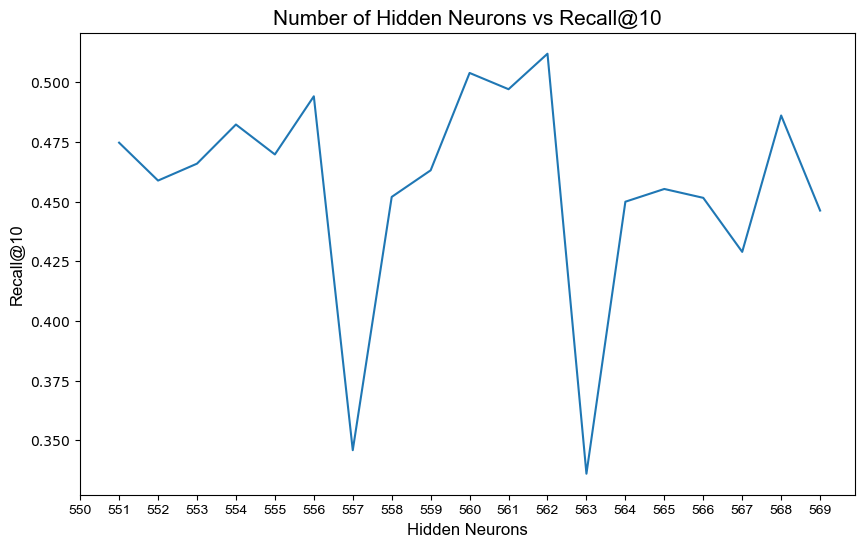

In [24]:
# Neurons averaged
avg_perf_neurons = df_tuning_3.groupby('hidden_neurons')['recall@10'].mean()

# Plot
plt.figure(figsize=(10,6))
plt.plot(avg_perf_neurons.index, avg_perf_neurons.values)
plt.title('Number of Hidden Neurons vs Recall@10',fontname='Arial', fontsize=15)
plt.xlabel('Hidden Neurons',fontname='Arial', fontsize=12)
plt.xticks(np.arange(550,570, step=1),fontname='Arial', fontsize=10)
plt.ylabel('Recall@10',fontname='Arial', fontsize=12)


plt.show()

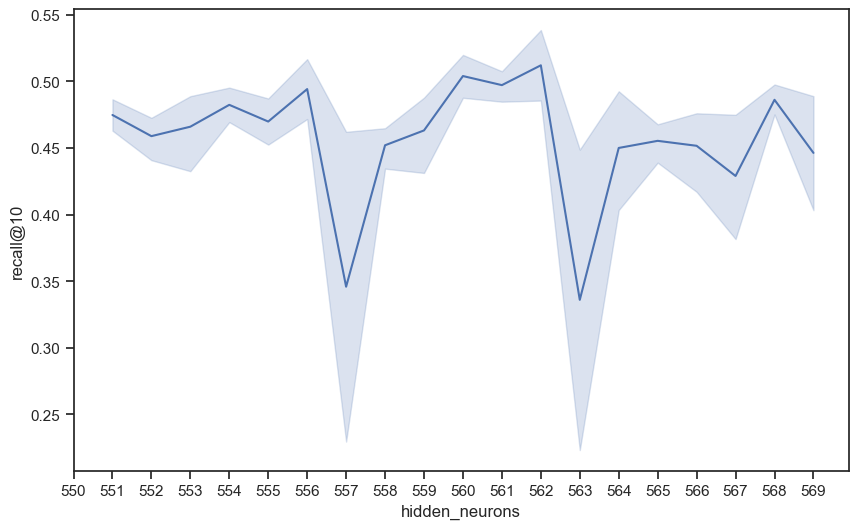

In [26]:
import seaborn as sns 
sns.set(rc={'figure.figsize':(10,6)})
sns.set_style("ticks")
ax = sns.lineplot(data=df_tuning_3, x='hidden_neurons', y='recall@10')
ax.set_xticks(np.arange(550,570, step=1))

# Best Model: Accuracy on Test

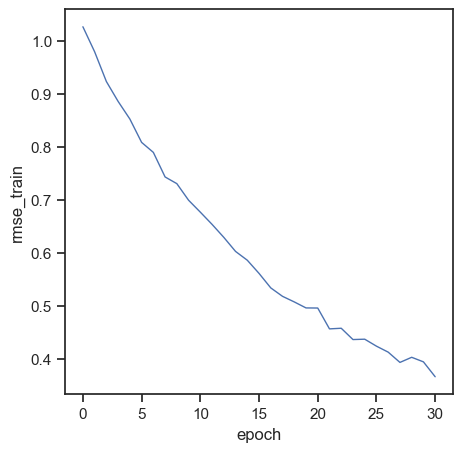

In [27]:
# Set up Model Object
best_model = RBM(possible_ratings=[1., 5.], # Always provide this range - way better results! 
                visible_units=Xtr.shape[1],
                hidden_units=562,
                training_epoch=30,
                minibatch_size=100,
                keep_prob=0.7,
                with_metrics=True,
                learning_rate=0.004,
                seed=42)
            
# Fit Model 
best_model.fit(Xtr)

# Line Graph
line_graph(values=best_model.rmse_train, labels='train', x_name='epoch', y_name='rmse_train')


In [28]:
# Make Predictions for entire Test Matrix
pred_test = best_model.predict(Xtst) ## Always Use Xtst for prediction - better results 

# Map Back Pred Test
pred_test = am_test.map_back_sparse(pred_test, kind = 'prediction')

# Merge test_pred with test
test_prediction_am = test_df.merge(pred_test, on=['StockCode', 'CustomerID'], how='left')

# Accuracy 
accuracy_score(test_prediction_am.purchased, test_prediction_am.prediction)

0.9929575423851615

In [32]:
pred_test.prediction.value_counts()

5.0    4922228
1.0    2024149
Name: prediction, dtype: int64